### Preprocessing Data

In [501]:
import pandas as pd
import geopandas as gpd
import shapely
import networkx as nx
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import pickle

# Data sources
# Default file names
filename_infrastructure = 'data_unwrangled/Centerline.csv'
filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'
filename_boundaries = 'data_unwrangled/2010 Neighborhood Tabulation Areas (NTAs).geojson'
filename_saved = 'data_unwrangled/flows.pickle'

In [274]:
def preprocess_infrastructure(filename, filter):
    # Load data
    infrastructure = pd.read_csv(filename)

    # Convert to geopandas format
    infrastructure = gpd.GeoDataFrame(infrastructure)
    infrastructure['the_geom'] = infrastructure['the_geom'].apply(shapely.wkt.loads)
    infrastructure.set_geometry('the_geom', inplace=True)

    # Restrict infrastructure to filter
    infrastructure_restricted = infrastructure.sjoin(filter)
    if 'index_right' in infrastructure.columns:
        infrastructure_restricted.drop(columns=['index_right'], inplace=True)
    infrastructure_restricted.drop_duplicates(subset=['PHYSICALID'], keep='first', inplace=True) # remove duplicates from join

    # Restrict to segments with in bicycle network
    infrastructure = infrastructure_restricted[infrastructure_restricted['BIKE_LANE'].notna()]

    # Add ID column
    infrastructure['segment_ID'] = infrastructure.index 

    # Create graph structure based on intersecting segments
    def get_neighbors(geometry, id):
        neighbors = infrastructure['segment_ID'].loc[infrastructure['the_geom'].intersects(geometry)].tolist()
        neighbors.remove(id)
        return neighbors
        
    infrastructure['neighbors'] = infrastructure.apply(lambda x: get_neighbors(x.the_geom, x.segment_ID), axis=1)

    # Ensure segments are connected
    graph = nx.from_pandas_edgelist(infrastructure.explode('neighbors'), source='segment_ID', target='neighbors')
    for subgraph in nx.connected_components(graph):
        if len(subgraph) > 1000:
            graph = graph.subgraph(subgraph)
    infrastructure = infrastructure.loc[list(graph.nodes())] # subset to connected nodes

    if 'index_right' in infrastructure.columns:
        infrastructure.drop(columns=['index_right'], inplace=True)

    return infrastructure

# Additional constraints like which way to turn, which roads meet at intersection

In [276]:
def preprocess_collisions(filename, filter, infrastructure):
    collisions = pd.read_csv(filename).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])

    # Restrict to collisions involving bicycles
    markers = ['bike', 'bicyc', 'e - b', 'e-bik', 'e-unicycle', 'bk']
    mask = collisions['VEHICLE TYPE CODE 1'].str.contains('bike') # placeholder
    for i in [1,2,3,4,5]:
        for marker in markers:
            mask = mask | collisions[f'VEHICLE TYPE CODE {i}'].str.contains(marker, case=False)
    collisions = collisions.loc[mask]

    # Restrict to filter
    collisions = collisions[collisions.LONGITUDE != 0] # remove 0,0 coordinates
    collisions = gpd.GeoDataFrame(collisions, geometry=gpd.points_from_xy(collisions.LONGITUDE, collisions.LATITUDE))

    collisions = collisions.sjoin(filter)
    if 'index_right' in collisions.columns:
        collisions.drop(columns=['index_right'], inplace=True)

    # Add ID column
    collisions['collision_ID'] = collisions.index 

    # Connect collisions to infrastructure
    collisions = collisions.sjoin_nearest(infrastructure, max_distance=0.0001, how='inner')
    if 'index_right' in collisions.columns:
        collisions.drop(columns=['index_right'], inplace=True)
    if 'index_left' in collisions.columns:
        collisions.drop(columns=['index_left'], inplace=True)

    collisions.drop_duplicates(subset=['collision_ID'], keep='first', inplace=True)

    ## Let's start in 2016 since previous years of citibike have far fewer rides
    start_date = pd.Timestamp('2016-01-01')
    collisions['CRASH DATE'] = pd.to_datetime(collisions['CRASH DATE'])
    collisions = collisions.loc[collisions['CRASH DATE'] >= start_date]

    return collisions

In [269]:
def preprocess_citibike(year, month, filter):
    year = '2016'
    month = '01'
    filename_citibike = f'data_unwrangled/citibike/{year}{month}-citibike-tripdata.csv'
    citibike = pd.read_csv(filename_citibike)

    citibike = gpd.GeoDataFrame(citibike)

    citibike['ride_ID'] = citibike.index 

    for type in ['start', 'end']:
        citibike[f'{type}_geom'] = gpd.points_from_xy(citibike[f'{type} station longitude'], citibike[f'{type} station latitude'])
        citibike.set_geometry(f'{type}_geom', inplace=True)
        citibike = citibike.sjoin(filter)
        if 'index_right' in citibike.columns:
            citibike.drop(columns=['index_right'], inplace=True)
        citibike.drop_duplicates(subset=['ride_ID'], keep='first', inplace=True)
        

    citibike['starttime'] = pd.to_datetime(citibike['starttime'])
    citibike['starttime_rounded'] = citibike['starttime'].dt.floor('d')
    citibike = citibike[citibike['tripduration'] <= 24 * 60 * 60]

    return citibike


In [270]:
def unique_stations(citibike, infrastructure):

    # Combine both start and end stations
    stations = {'start': {}, 'end': {}}
    for type in ['start', 'end']:
        renaming = {f'{type} station id': 'station_id', f'{type}_geom': 'geometry'}
        stations[type] = citibike.drop_duplicates(subset=[f'{type} station id'], keep='first').rename(columns=renaming)
        stations[type] = stations[type][renaming.values()]
    stations = pd.concat([stations['start'], stations['end']])
    
    # Remove duplicates
    stations.drop_duplicates(subset=['station_id'], keep='first', inplace=True)

    # Find nearby segments
    stations = stations.set_geometry('geometry')
    stations = stations.sjoin_nearest(infrastructure, max_distance=0.01, how='left')
    if 'index_right' in stations.columns:
        stations.drop(columns=['index_right'], inplace=True)
    stations.drop_duplicates(subset=[f'station_id'], keep='first', inplace=True)

    return stations

In [277]:
# Load filter of Manhattan
# Perhaps get a *connected* filter?
filter = gpd.read_file(filename_boundaries)
filter = filter[filter['boro_name'] == 'Manhattan']

infrastructure = preprocess_infrastructure(filename_infrastructure, filter)
collisions = preprocess_collisions(filename_collisions, filter, infrastructure)
citibike = preprocess_citibike(year='2016', month='01', filter=filter)
stations = unique_stations(citibike, infrastructure)

/var/folders/0n/hqwrwrp96x3g_q8dnhlmvghh0000gn/T/ipykernel_12356/3982972818.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(filename).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])
/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/Users/rtealwitter/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:2090: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, 

In [453]:
graph = nx.from_pandas_edgelist(infrastructure.explode('neighbors'), source='segment_ID', target='neighbors')
nodes = list(graph.nodes())
Laplacian = nx.laplacian_matrix(graph, nodelist=nodes)
Lpinv = linalg.pinv(Laplacian.todense())
with open(filename_saved, 'rb') as pickle_file:
    saved = pickle.load(pickle_file)

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [465]:
station_to_segment = dict(zip(stations.station_id, stations.segment_ID))
segment_to_index = {segment_ID : nodes.index(segment_ID) for segment_ID in infrastructure['segment_ID']}

def calculate_flow(start, end, count):
    assert start != end
    start = station_to_segment[start]
    end = station_to_segment[end]
    key = (start, end) if start < end else (end, start)
    if key not in saved:
        Lpinv_vector = Lpinv[nodes.index(start)] - Lpinv[nodes.index(end)]
        resistance = Lpinv_vector[0, nodes.index(start)] - Lpinv_vector[0, nodes.index(end)]
        if resistance != 0:
            voltages = (Lpinv_vector/resistance).round(5)[0]

            def letitflow(segment_ID, neighbors):
                own = voltages[segment_to_index[segment_ID]]
                return sum([(voltages[segment_to_index[neighbor]]-own)**2 for neighbor in neighbors])

            vectorized = np.vectorize(lambda x, y : letitflow(x, y))

            saved[key] = vectorized(infrastructure.segment_ID, infrastructure.neighbors)
        else: 
            saved[key] = np.zeros(len(infrastructure['segment_ID']), dtype=np.float64)
    
    return count*saved[key]

In [515]:
i = 13
day = citibike['starttime_rounded'].unique()[i]
citibike_day = citibike[citibike['starttime_rounded']==day][['start station id', 'end station id']]
grouped = citibike_day.groupby(['start station id', 'end station id']).size().reset_index(name='count')
grouped = grouped[grouped['start station id'] != grouped['end station id']]

In [516]:
total = np.zeros(len(infrastructure['segment_ID']), dtype=np.float64)
for (start, end, count) in zip(grouped['start station id'], grouped['end station id'], grouped['count']):
    total += calculate_flow(start, end, count)
# Ensure each segment has at least some flow
minimum = total[total != 0].min()
total[total == 0] = minimum

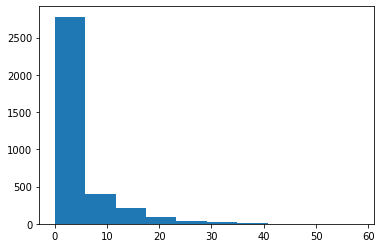

0
2.1000000000013062e-08
2.1000000000013062e-08


In [509]:
plt.hist(total)
plt.show()

In [518]:
with open(filename_saved, 'wb') as pickle_file:
    pickle.dump(saved, pickle_file)
